In [1]:
import obspy
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from scatseisnet import ScatteringNetwork
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import dates as mdates
import sklearn.decomposition
from sklearn.decomposition import FastICA, PCA
from sklearn.cluster import KMeans, DBSCAN
import umap
from tqdm.auto import tqdm
from pathlib import Path
import pandas as pd

In [2]:
base_dir = Path("../data/space_apps_2024_seismic_detection")
cat_file = base_dir / "data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
cat = pd.read_csv(cat_file)
# for convenient access
cat["arrival_time"] = pd.to_datetime(cat["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
cat["arrival_time_rel"] = cat["time_rel(sec)"]

train_dir = base_dir / "data/lunar/training/data/"
test_dir = base_dir / "data/lunar/test/data/"

# get from df so we can match with arrival times
train_filenames = [train_dir / f"S12_GradeA/{x}.mseed" for x in cat.filename]
test_filenames = list(test_dir.rglob("*.mseed"))

print("training data: ", len(list(train_dir.rglob("*.mseed"))))
print("test data: ", len(test_filenames))

for i, f in enumerate(train_filenames):
    if "evid00029" in str(f):
        train_filenames[i] = Path(
            "../data/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR02_evid00029.mseed"
        )
train_streams = []
for f in train_filenames:
    try:
        train_streams.append(obspy.read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

test_streams = []
for f in test_filenames:
    try:
        test_streams.append(obspy.read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

training data:  76
test data:  96


In [24]:
# train_filenames[0].name
# print('\n'.join([x.name for x in train_filenames]))

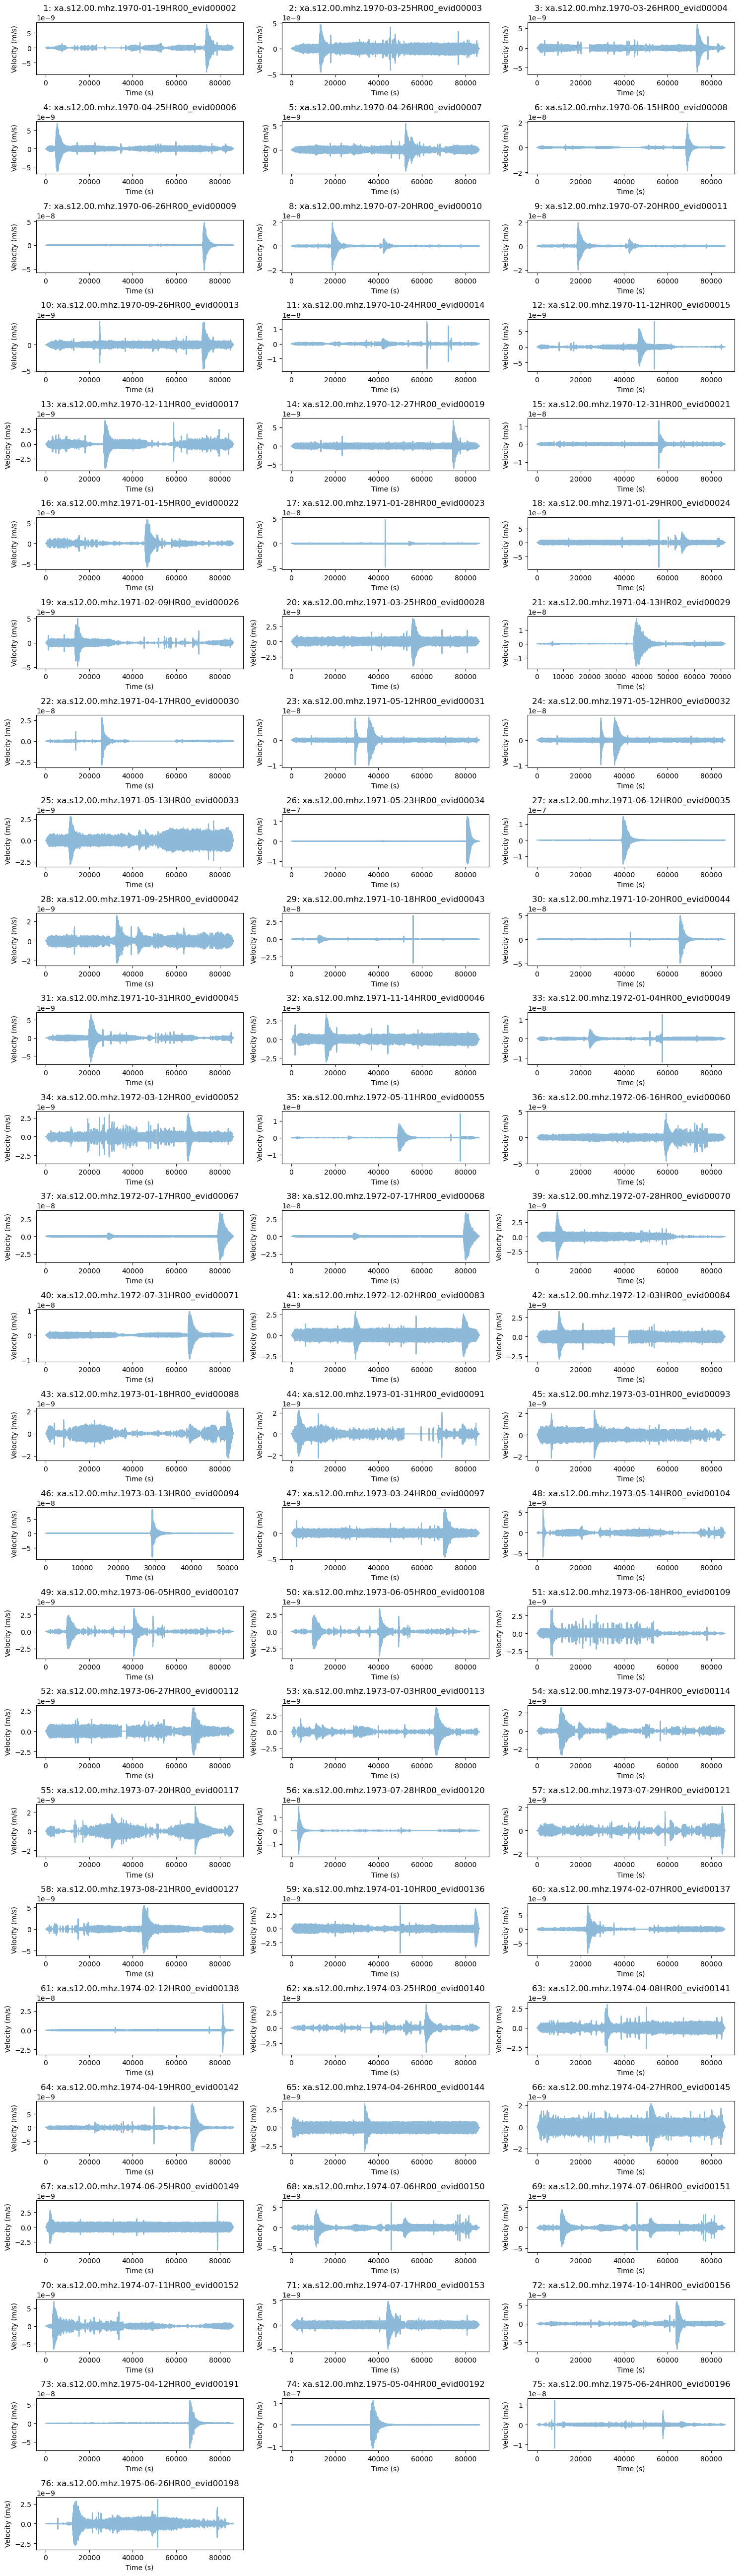

In [4]:
def get_time_speed(stream: obspy.core.stream.Stream):
    # all have just one trace
    trace = stream[0]
    tr_times = trace.times()
    tr_data = trace.data
    return tr_times, tr_data


nrows = (len(train_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()


for i, stream in enumerate(train_streams):
    x, y = get_time_speed(stream)
    axs[i].plot(x, y, alpha=0.5)
    axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Velocity (m/s)")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

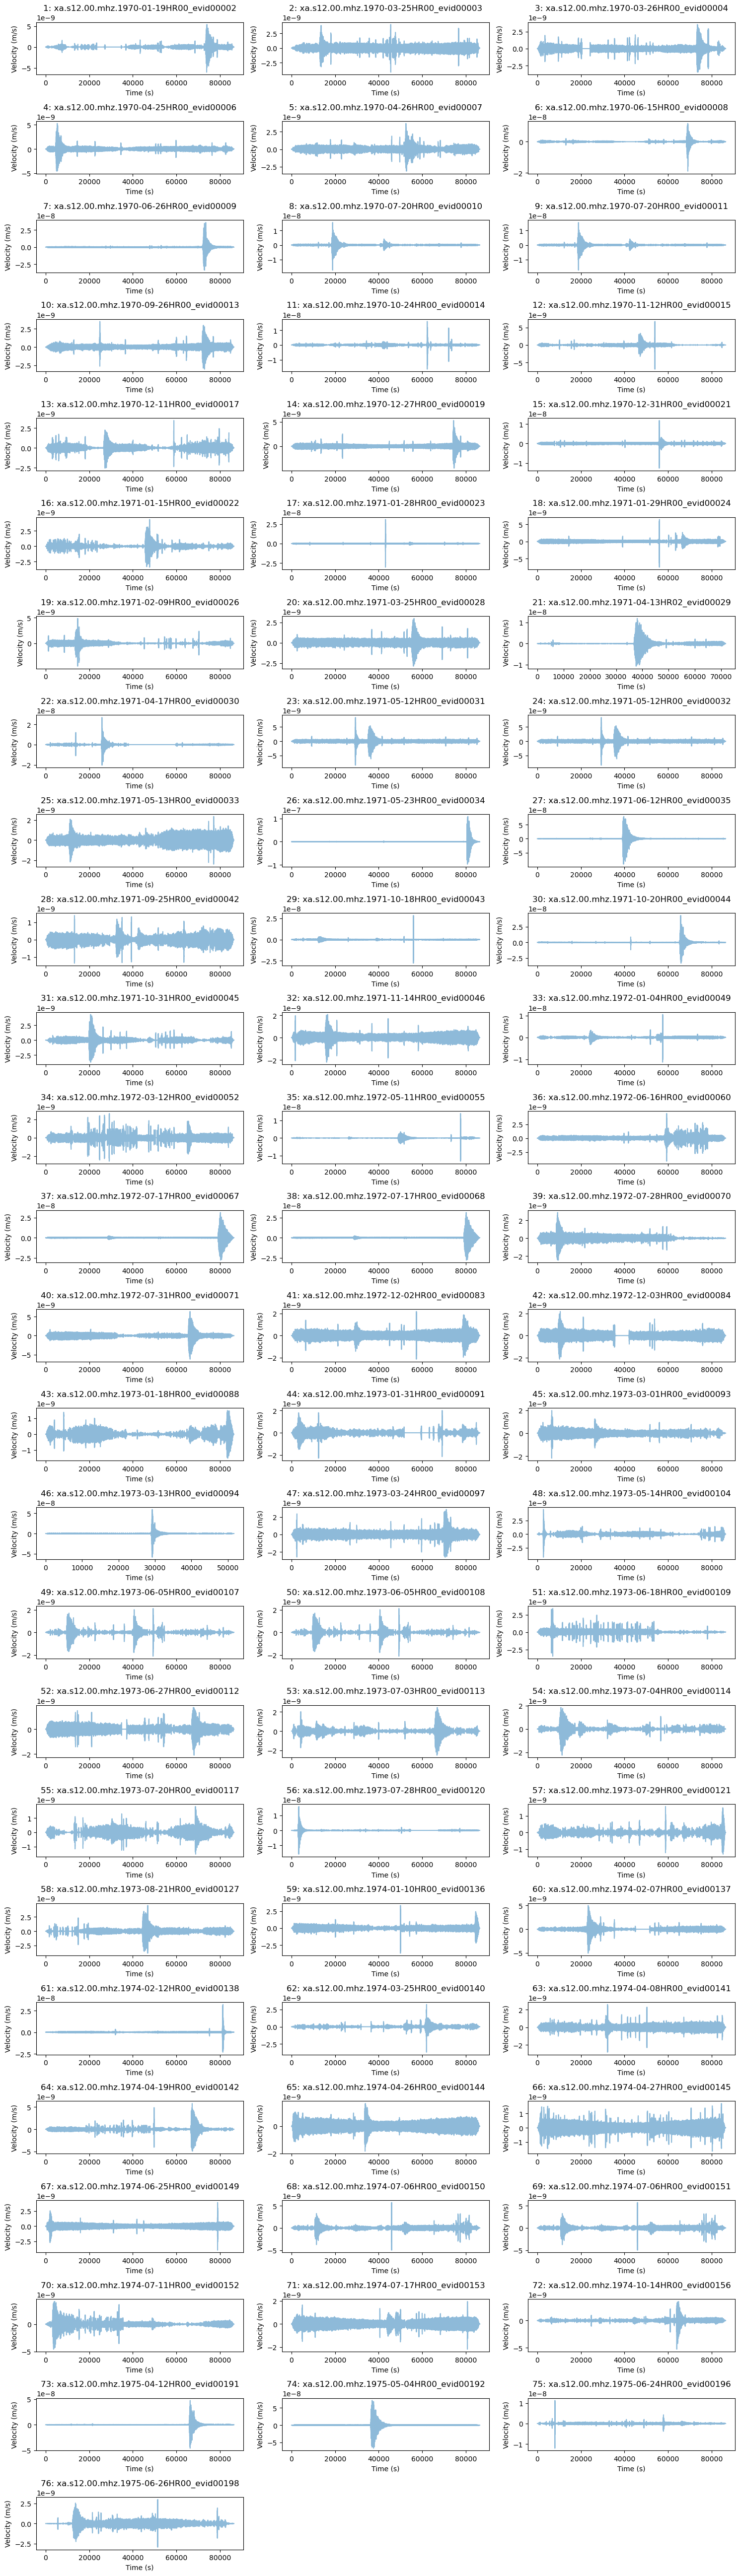

In [15]:
nrows = (len(train_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()


for i, stream in enumerate(train_streams):
    stream_cpy = stream.copy()
    stream_cpy.filter("lowpass", freq=1.0)
    stream_cpy[0].resample(2)
    x, y = get_time_speed(stream_cpy)
    axs[i].plot(x, y, alpha=0.5)
    axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Velocity (m/s)")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

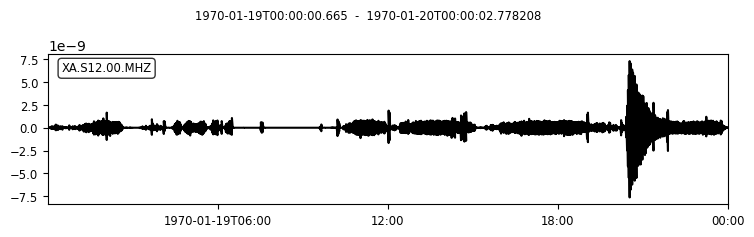

In [7]:
# Create a copy of the stream to avoid modifying the original
filtered_stream = train_streams[0].copy()

# Apply a lowpass filter to remove frequencies above 1 Hz
filtered_stream.filter("lowpass", freq=1.0)

# Plot the filtered stream
filtered_stream.plot()
plt.show()

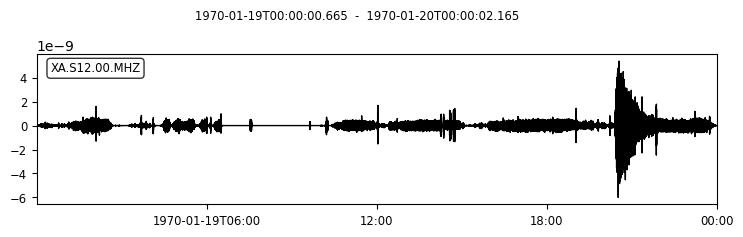

In [13]:
# Create a copy of the stream to avoid modifying the original
filtered_stream = train_streams[0].copy()

# Apply a lowpass filter to remove frequencies above 1 Hz
filtered_stream.filter("lowpass", freq=1.0)

# Downsample to 2 samples per second
target_sampling_rate = 2  # Hz
filtered_stream[0].resample(target_sampling_rate)

# Plot the filtered and downsampled stream
filtered_stream.plot()
plt.show()

In [25]:
train_streams[0][0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-01-19T00:00:00.665000Z
         endtime: 1970-01-20T00:00:02.778208Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572415
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [14]:
filtered_stream[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-01-19T00:00:00.665000Z
         endtime: 1970-01-20T00:00:02.165000Z
   sampling_rate: 2.0
           delta: 0.5
            npts: 172804
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})
      processing: ["ObsPy 1.4.1: filter(options={'freq': 1.0}::type='lowpass')", "ObsPy 1.4.1: resample(no_filter=True::sampling_rate=2::strict_length=False::window='hann')"]